# UJM - Master DSC/MLDM - Deep Learning - TP1b - Images

## Objectives

In this practical session, we will deal with images and try to reproduce results on the famous MNIST Dataset

### Part 1 - Pytorch and MNIST basic

Importing Torch and MNIST

In [25]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# converting PIL to tensor already divides by 255

trainset = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = torchvision.datasets.MNIST('./', download=True, train=False, transform=transform)

**Note** MNIST contains handwriting data of 10 numbers; each image has size 28 * 28. We display some examples below

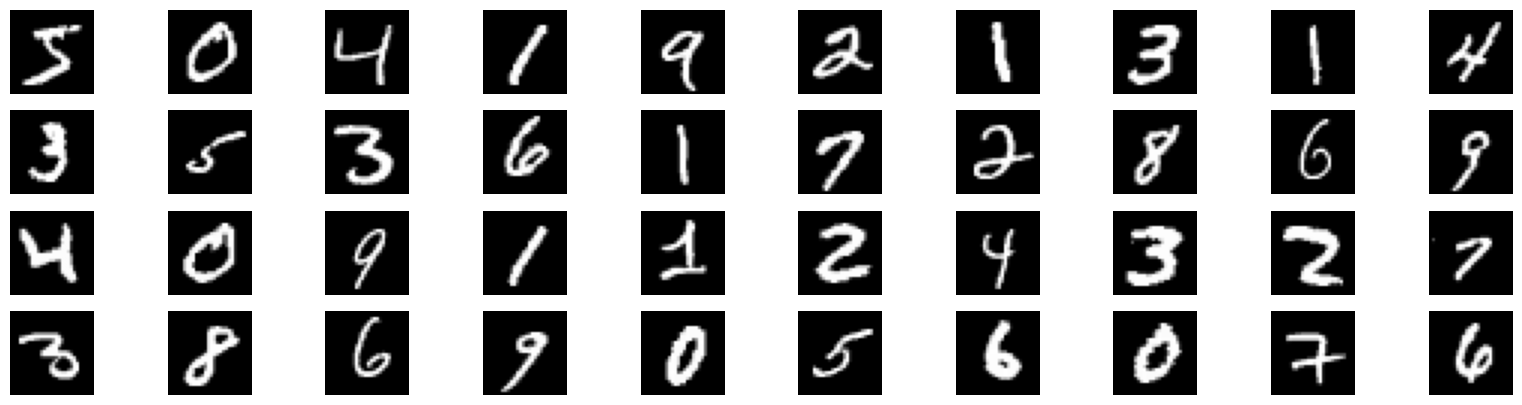

labels:  tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6])


/Users/buudinhha/PycharmProjects/deep-learning-2/DL_TP1/pytorch/env/lib/python3.13/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [39]:

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for i in range(40):
    plt.subplot(4, 10, i+1)
    example = trainset.data[i].numpy().squeeze()
    plt.imshow(example, cmap = 'gray')
    plt.axis('off')
plt.show()
print('labels: ', trainset.train_labels[:40])

**Note** We are skipping the data normalizing which is present
in the keras version of this session as the data loaded from the torch
is already normalized for our requirement.

- Now we load the data into a dataloader

In [40]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

**Note** now we display two images

## Let's start with fully connected neural networks (NN)
They are also called multi layered perceptrons (MLP).

In that case, the sequential model of torch is used mainly because its more simple (for a discusion on several pytorch modes see for instance https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict).

MLP have fully connected layers called `Linear` in pytorch (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

In [41]:
def train(epochs, model, trainloader, loss_fn, optimizer):
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader,0):
            # zero the parameter gradients
            inputs, labels = data
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.view(-1, 784))
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

    print('Finished Training')
    
# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model, testloader):

    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images.view(-1, 784))
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

**Next step**
Now we are going to define the train function and train the NN.
The first step here is to define the loss funtion (the loss) and the learning algorithm.
A natural choice for the loss is the `categorical_crossentropy` well suited for multiclass classification.
As a learning algorithm, let's began with the simple stochastic gradient descent optimizer, with default parameter initialization (that is a learning rate set at $0.01$).
The second step consist in fitting the NN to the data.
By setting the `verbose` parameter to 0 (no outputs during training), the computing time is significantly reduced.
This training phase may take about one minute.

**Next** The quality of this NN is determined by measuring its error rate on the test set.

So we will define the function to get test accuray and run it.

In [49]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 300),
    torch.nn.Tanh(),
    torch.nn.Linear(300, 10),
)

from torchsummary import summary
summary(model, (1, 28, 28))

# Using Adam optimizer to optimize weights of the Neural Network
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(epochs=10, model=model, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=model, testloader=testloader)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              Tanh-3                  [-1, 300]               0
            Linear-4                   [-1, 10]           3,010
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.91
Estimated Total Size (MB): 0.92
----------------------------------------------------------------
[1,    10] loss: 2.293
[1,    20] loss: 2.248
[1,    30] loss: 2.198
[1,    40] loss: 2.160
[1,    50] loss: 2.121
[1,    60] loss: 2.083
[1,    70] loss: 2.033
[1,    80] loss: 1.996
[1,    90] loss: 1.957
[1,   100] loss: 1.908
[1,   110] loss: 1.864
[1,   120] loss: 1.844
[1,   130] loss: 1.808

92.16

**Question** Try to retrain the same model but by replacing the 'tanh' activation by a 'relu' activation, what happens?

In [50]:
model1 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 10),
)

summary(model1, (1, 28, 28))

optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(epochs=10, model=model1, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=model1, testloader=testloader)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                   [-1, 10]           3,010
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.91
Estimated Total Size (MB): 0.92
----------------------------------------------------------------
[1,    10] loss: 2.305
[1,    20] loss: 2.291
[1,    30] loss: 2.272
[1,    40] loss: 2.244
[1,    50] loss: 2.229
[1,    60] loss: 2.214
[1,    70] loss: 2.199
[1,    80] loss: 2.173
[1,    90] loss: 2.160
[1,   100] loss: 2.143
[1,   110] loss: 2.115
[1,   120] loss: 2.099
[1,   130] loss: 2.057

93.24

### Second try
Ok, let's improve our training a little bit by introduicing some punch in our optimizer.
To do so we add a momentum term (`momentum=0.9`) and some L2 penalty (`decay=1e-6`). This is done by  replacing the instruction `optimizer = torch.optim.SGD(model.parameters(), lr=0.01),`  by  `optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 1e-6, momentum = 0.9, nesterov = False), `
 and resume training in the same way as we just did (it may take about one minute).

In [51]:
model2 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 300),
    torch.nn.Tanh(),
    torch.nn.Linear(300, 10),
)

optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, weight_decay = 1e-6, momentum = 0.9, nesterov = False)
loss_fn = torch.nn.CrossEntropyLoss()

summary(model2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              Tanh-3                  [-1, 300]               0
            Linear-4                   [-1, 10]           3,010
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.91
Estimated Total Size (MB): 0.92
----------------------------------------------------------------


In [52]:
train(epochs=1, model=model2, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=model2, testloader=testloader)

[1,    10] loss: 2.247
[1,    20] loss: 1.999
[1,    30] loss: 1.636
[1,    40] loss: 1.363
[1,    50] loss: 1.031
[1,    60] loss: 0.919
[1,    70] loss: 0.762
[1,    80] loss: 0.740
[1,    90] loss: 0.631
[1,   100] loss: 0.599
[1,   110] loss: 0.568
[1,   120] loss: 0.518
[1,   130] loss: 0.524
[1,   140] loss: 0.521
[1,   150] loss: 0.484
[1,   160] loss: 0.424
[1,   170] loss: 0.489
[1,   180] loss: 0.447
[1,   190] loss: 0.454
[1,   200] loss: 0.478
[1,   210] loss: 0.499
[1,   220] loss: 0.381
[1,   230] loss: 0.411
[1,   240] loss: 0.407
[1,   250] loss: 0.411
[1,   260] loss: 0.395
[1,   270] loss: 0.367
[1,   280] loss: 0.401
[1,   290] loss: 0.364
[1,   300] loss: 0.436
[1,   310] loss: 0.408
[1,   320] loss: 0.385
[1,   330] loss: 0.403
[1,   340] loss: 0.344
[1,   350] loss: 0.374
[1,   360] loss: 0.345
[1,   370] loss: 0.360
[1,   380] loss: 0.406
[1,   390] loss: 0.400
[1,   400] loss: 0.376
[1,   410] loss: 0.406
[1,   420] loss: 0.329
[1,   430] loss: 0.348
[1,   440] 

91.7

**Next** We evaluate

### Third try

There is still room for some improvement. Let's try the same architecture with another optimizer.
Try the `Adadelta` optimizer with default parameters(it may take about one minute).
To do so, replace the instruction  `optimizer=ttorch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 1e-6, momentum = 0.9, nesterov = False),` by  `optimizer=torch.optim.Adadelta(model.parameters(), lr=0.01), `

We retrain the model and evaluate

In [53]:
model3 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 300),
    torch.nn.Tanh(),
    torch.nn.Linear(300, 10),
)
summary(model3, (1, 28, 28))

optimizer = torch.optim.Adadelta(model3.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(epochs=10, model=model3, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=model3, testloader=testloader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              Tanh-3                  [-1, 300]               0
            Linear-4                   [-1, 10]           3,010
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.91
Estimated Total Size (MB): 0.92
----------------------------------------------------------------
[1,    10] loss: 2.299
[1,    20] loss: 2.278
[1,    30] loss: 2.253
[1,    40] loss: 2.228
[1,    50] loss: 2.199
[1,    60] loss: 2.184
[1,    70] loss: 2.153
[1,    80] loss: 2.136
[1,    90] loss: 2.099
[1,   100] loss: 2.084
[1,   110] loss: 2.060
[1,   120] loss: 2.044
[1,   130] loss: 2.015

91.34

### Fourth try

In the MNIST leaderboad, with a 3-layer NN, 500+300 HU, softmax, cross entropy, weight decay, Hinton, reproted in 2005 an error rate of 1.53%. For fun we can use a ReLU activation function. The training phase takes about 5 minutes.

We retrain and evaluate

In [54]:
model4 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 300),
    torch.nn.Tanh(),
    torch.nn.Linear(300, 10),
)

summary(model4, (1, 28, 28))

optimizer = torch.optim.Adam(model4.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(epochs=10, model=model4, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=model4, testloader=testloader)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 300]         150,300
              Tanh-5                  [-1, 300]               0
            Linear-6                   [-1, 10]           3,010
Total params: 545,810
Trainable params: 545,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.08
Estimated Total Size (MB): 2.10
----------------------------------------------------------------
[1,    10] loss: 1.589
[1,    20] loss: 0.656
[1,    30] loss: 0.614
[1,    40] loss: 0.554
[1,    50] loss: 0.395
[1,    60] loss: 0.386
[1,    70] loss: 0.361
[1,    80

94.38

## Let's continue with Convolutional neural networks (CNN)

In the MNIST leaderboad, LeCun et al. 1998 reported with LeNet-5 an error rate of 0.95%.
LeNet-5 is a convolutional neural network.

<img src="https://www.jeremyjordan.me/content/images/2018/04/Screen-Shot-2018-04-16-at-11.34.51-AM.png" alt="MNIST data" width="360" height="270" border="5" />

Convolution used to process images are 2d convolutions taking tensors as input and output.
To fit into the first 2d convolutional layer, the input have to be recast as tensor of dimension $28 \times 28 \times 1$. This can be performed by using a reshape.

## First try with CNN
With a simplified version of LeNet-5 and with ReLU instead of hyperbolic tangent as activation function. It takes about 3 minutes.


In [55]:
def train(epochs, model, trainloader, loss_fn, optimizer):
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader,0):
            # zero the parameter gradients
            inputs, labels = data
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

    print('Finished Training')
    
def testAccuracy(model, testloader):
    
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [56]:
CNN = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(6, 16, kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10),
)

summary(CNN, (1, 28, 28))

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), eps=1e-07) 

train(epochs=1, model=CNN, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=CNN, testloader=testloader)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                  [-1, 120]          30,840
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
---------------------------------

97.45

## Second try
With a CNN slightly more complex

**Next** we proceed to the training in the same way, using `Adam` as optimizer. It may take about 15 minutes.

In [58]:
CNN2 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Dropout(p=0.25),
    torch.nn.Flatten(),
    torch.nn.Linear(7744, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(128, 10),
)
summary(CNN2, (1, 28, 28))

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN2.parameters(), lr=0.001)  

train(epochs=2, model=CNN2, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=CNN2, testloader=testloader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 64, 22, 22]          18,496
              ReLU-4           [-1, 64, 22, 22]               0
         MaxPool2d-5           [-1, 64, 11, 11]               0
           Dropout-6           [-1, 64, 11, 11]               0
           Flatten-7                 [-1, 7744]               0
            Linear-8                  [-1, 128]         991,360
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 1,011,978
Trainable params: 1,011,978
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

98.45

**Question** Can you improve these results by using other activation functions (e.g. 'relu')?

It already uses relu?

**Question** Can you improve the results above with more complex architectures?

In [59]:
import torch.nn as nn
import torch.optim as optim
import time

CNN3 = nn.Sequential(
    # First conv block
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.25),
    
    # Second conv block
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.25),
    
    # Fully connected layers
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 512),  
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 10)
)

optimizer = optim.Adam(CNN3.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

summary(CNN3, (1, 28, 28))

train(epochs=1, model=CNN3, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=CNN3, testloader=testloader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
           Dropout-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          18,496
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          36,928
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

98.58

# Part 3 Other dataset

try to do your best with another version of this dataset: fashion_MNIST

100.0%
100.0%
100.0%
100.0%


train data:	 torch.Size([60000, 28, 28])
test data:	 torch.Size([10000, 28, 28])


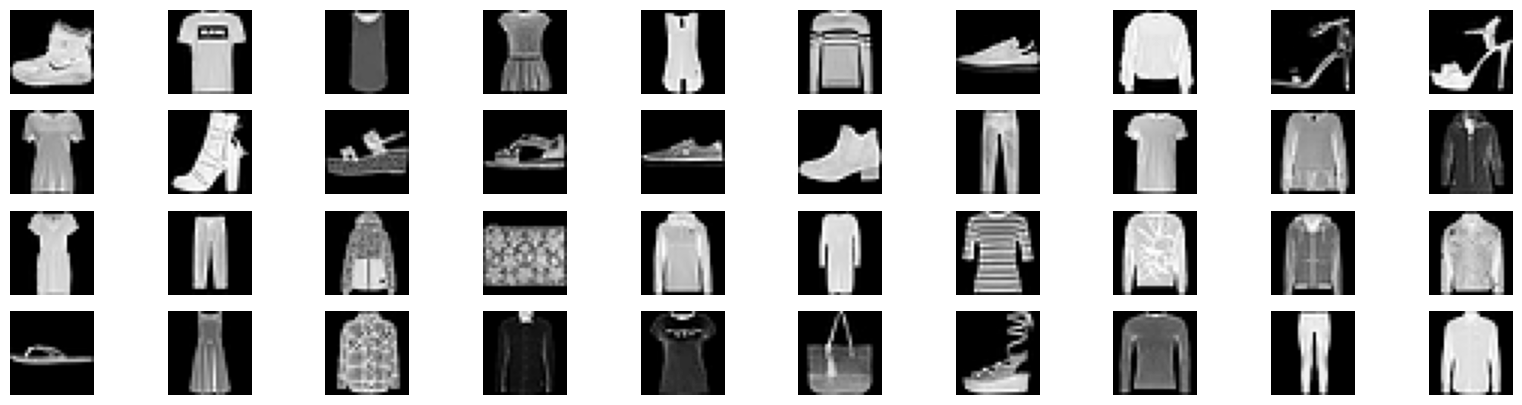

labels:  tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6])


/Users/buudinhha/PycharmProjects/deep-learning-2/DL_TP1/pytorch/env/lib/python3.13/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [60]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transform)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transform)

print('train data:\t', train_set.data.shape)
print('test data:\t', test_set.data.shape)

plt.figure(figsize=(20,5))

for i in range(40):
    plt.subplot(4, 10, i+1)
    example = train_set.data[i].numpy().squeeze()
    plt.imshow(example, cmap = 'gray')
    plt.axis('off')
plt.show()
print('labels: ', train_set.train_labels[:40])


In [61]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [63]:
CNN4 = nn.Sequential(
    # First conv block
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.25),
    
    # Second conv block
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.25),
    
    # Fully connected layers
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 512),  
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 10)
)

optimizer = optim.Adam(CNN4.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

summary(CNN4, (1, 28, 28))

train(epochs=2, model=CNN4, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=CNN4, testloader=testloader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
           Dropout-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          18,496
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          36,928
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

90.71

**Bonus**
if you have time, you can try to addresse the CIFAR dataset

100.0%


train data:	 (50000, 32, 32, 3)
test data:	 (10000, 32, 32, 3)


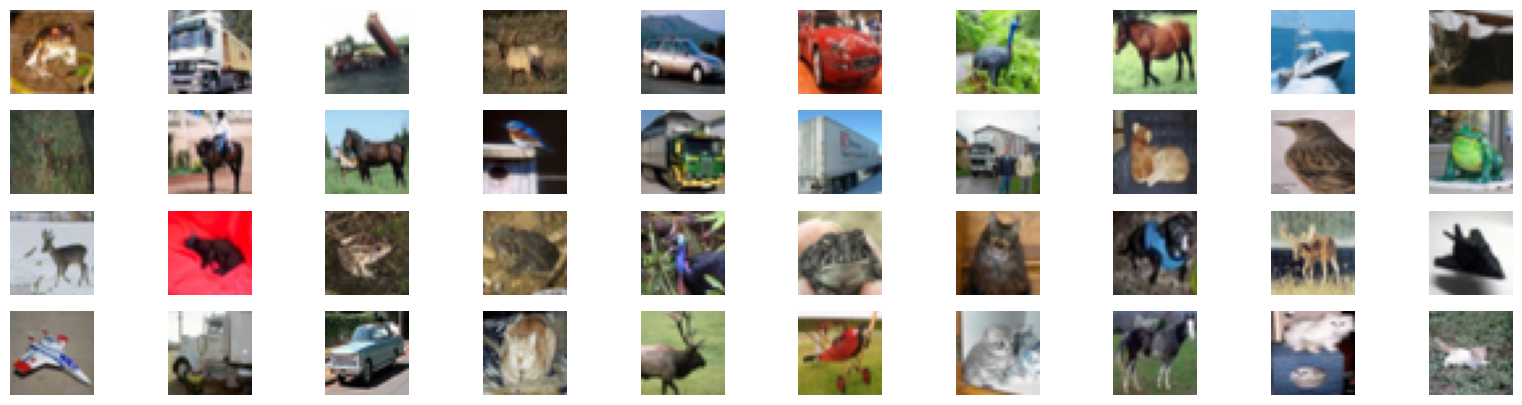

labels:  [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3]


In [64]:
train_set = torchvision.datasets.CIFAR10("./data", download=True, transform=
                                                transform)
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transform)

print('train data:\t', train_set.data.shape)
print('test data:\t', test_set.data.shape)

plt.figure(figsize=(20,5))

for i in range(40):
    plt.subplot(4, 10, i+1)
    example = train_set.data[i]
    plt.imshow(example, cmap = 'gray')
    plt.axis('off')
plt.show()
print('labels: ', train_set.targets[:40])

In [65]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [68]:
CNN5 = nn.Sequential(
    # First conv block
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.25),
    
    # Second conv block
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.25),
    
    # Fully connected layers
    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 512),  
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 10)
)

optimizer = optim.Adam(CNN5.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

summary(CNN5, (3, 32, 32))

train(epochs=2, model=CNN5, trainloader=trainloader, loss_fn=loss_fn, optimizer=optimizer)
testAccuracy(model=CNN5, testloader=testloader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
           Dropout-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

73.64

## Torch version

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

**Final Question** Write down the similarities and differences between torch and keras version of the notebooks below.

### Similarities
- We follow the same overall structure, model architecture, training config
### Differences
- Data preprocessing: keras - manual normalization, pytorch - normalization handled by ToTensor()
- Model definition: diffrent syntax, no explicit softmax when defining model for pytorch since CrossEntropyLoss includes it
- Training: keras - high-level API: compile then fit, pytorch - manual implemenation
- Evaluation: keras - high-level API: evaluate to get score, pytorch - manual implemenation